In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import json


import ritnet
from ritnet.dataset import IrisDataset, transform
from torch.utils.data import DataLoader 
from ritnet.opt import parse_args
from ritnet.models import model_dict
from ritnet.utils import get_predictions


In [3]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

In [4]:
device='cpu'

In [5]:
model = model_dict['densenet']
model  = model.to(device)
filename = '../../RITnet/best_model.pkl'

In [6]:
if not os.path.exists(filename):
    print("model path not found !!!")
else:
    print('model load ok!')

model load ok!


In [7]:
model.load_state_dict(torch.load(filename))
model = model.to(device)
model.eval()

DenseNet2D(
  (down_block1): DenseNet2D_down_block(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(33, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv31): Conv2d(65, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): AvgPool2d(kernel_size=None, stride=None, padding=0)
    (relu): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (dropout3): Dropout(p=0.2, inplace=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_block2): DenseNet2D_down_block(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=

In [8]:
test_set = IrisDataset(filepath = 'Semantic_Segmentation_Dataset/',\
                                 split = 'test',transform = transform)
    
testloader = DataLoader(test_set, batch_size = 4,
                             shuffle=False, num_workers=2)

In [51]:
test_set.

In [9]:
counter=0
    
os.makedirs('test/labels/',exist_ok=True)
os.makedirs('test/output/',exist_ok=True)
os.makedirs('test/mask/',exist_ok=True)

In [9]:
import nia22
import cv2

In [46]:
from glob import glob
import random

In [47]:
fn_

'NIA22EYE_S1_007_T1_S09_L_rgb_A_U_T_156.png'

In [62]:
out_dir = "../../RITnet/NIA2022/test/images/"

ddir = "/home/di/Work/data/NIA2022/Refined/0804/"
fnlist = glob(ddir + "refined_json/NIA22EYE_S1_007*.json")
random.shuffle(fnlist)

for fn_json in fnlist[:120]: 
    fn_png  = fn_json.replace("json", "png")
    img = cv2.cvtColor(cv2.imread(fn_png), cv2.COLOR_BGR2RGB)
    fn_out = out_dir + fn_png.split("/")[-1]

    anno = json.load(open(fn_json))

    eye = nia22.eyes.Eye(anno["annotations"])

    area, cropped = nia22.eyes.crop_eye(img, np.array(eye.l_eyelid['points']))

    lcx, lcy = np.mean(eye.l_iris['points'], axis=0)
    lrx, lry = np.ptp(eye.l_iris['points'], axis=0)

    rcx, rcy = np.mean(eye.r_iris['points'], axis=0)
    rrx, rry = np.ptp(eye.r_iris['points'], axis=0)

    eye.l_center={"label":"l_center", 'points':[[lcx,lcy]]}
    eye.r_center={"label":"r_center", 'points':[[rcx,rcy]]}

    eye.l_iris.update({'cx':lcx, 'cy':lcy, 'rx':lrx, 'ry':lry})
    eye.r_iris.update({'cx':rcx, 'cy':rcy, 'rx':rrx, 'ry':rry})

    area, cropped = nia22.eyes.crop_eye(img, np.array(eye.l_eyelid['points']))

    if cropped.shape[0] > 60:
        cv2.imwrite(fn_out.replace(".png", "_l.png"),
                    cv2.cvtColor(cv2.resize(cropped, (400, 640))
                                ,cv2.COLOR_RGB2BGR))
    
    area, cropped = nia22.eyes.crop_eye(img, np.array(eye.r_eyelid['points']))
    if cropped.shape[0] > 60:
        cv2.imwrite(fn_out.replace(".png", "_r.png"),
                    cv2.cvtColor(cv2.resize(cropped, (400, 640))
                                ,cv2.COLOR_RGB2BGR))

In [63]:
test_set = IrisDataset(filepath = "../../RITnet/NIA2022/",\
                                 split = 'test',transform = transform)
    
testloader = DataLoader(test_set, batch_size = 4,
                             shuffle=False, num_workers=2)

100%|██████████████████████████████████| 45/45 [00:34<00:00,  1.29it/s]


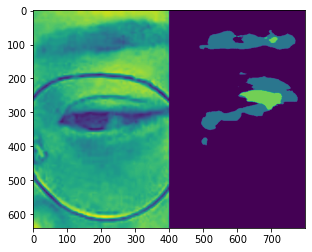

In [64]:
with torch.no_grad():
    for i, batchdata in tqdm(enumerate(testloader),total=len(testloader)):
        img,labels,index,x,y= batchdata
        data = img.to(device)       
        output = model(data)            
        predict = get_predictions(output)
#         for j in range (len(index)):       
#             np.save('test/labels/{}.npy'.format(index[j]),predict[j].cpu().numpy())
#             try:
#                 plt.imsave('test/output/{}.jpg'.format(index[j]),255*labels[j].cpu().numpy())
#             except:
#                 pass
        if True:
            pred_img = predict[j].cpu().numpy()/3.0
            inp = img[j].squeeze() * 0.5 + 0.5
            img_orig = np.clip(inp,0,1)
            img_orig = np.array(img_orig)
            combine = np.hstack([img_orig,pred_img])
            plt.imsave('../../RITnet/NIA2022/test/{}.jpg'.format(index[j]),combine)
            plt.imshow(combine)

In [20]:
# single image test

In [80]:
from PIL import Image
import cv2
import numpy as np
from torchvision import transforms

In [141]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [142]:
img = Image.open('Semantic_Segmentation_Dataset/test/images/NIA_EYE_U1_053_VR_IR_F_REYE_0901.png').convert("L")
H, W = img.width , img.height

table = 255.0*(np.linspace(0, 1, 256)**0.8)
img = cv2.LUT(np.array(img), table)
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
img = clahe.apply(np.array(np.uint8(img)))    
img = Image.fromarray(img)
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
#img = transform(img)
# img = np.array(img)
# img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img).type(torch.FloatTensor)

In [143]:
data = img.to(device)
output = model(data)

In [150]:
predict = get_predictions(output)
pred_img = predict.cpu().numpy()/3.0

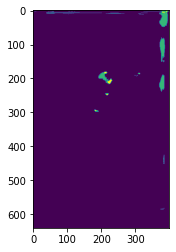

In [152]:
plt.imshow(pred_img[0])